# Task 2
Train a simple CNN model with LogMelFilterBanks features for a binary classification problem

### Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

import torch
import torch.nn as nn 
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.optim import AdamW
import torchaudio
from torchaudio.transforms import MelSpectrogram
from torchaudio.datasets import SPEECHCOMMANDS
from melbanks import LogMelFilterBanks

import random
import time
from pthflops import count_ops
import tqdm


In [4]:
# Fixed random state
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Loading and splitting data

In [6]:
class BinarySubset(SPEECHCOMMANDS):
    def __init__(self, subset: str = None, sample_rate: int = 16000):
        super().__init__("./", download=True)
        self.sample_rate = sample_rate
        self.classes = ['yes', 'no']

        def load_list(data):
            filepath = os.path.join(self._path, data)
            print(self._path)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

        # Filter target classes
        self._walker = [w for w in self._walker if self.get_label_from_path(w) in self.classes]

    def get_label_from_path(self, path):
        return os.path.normpath(path).split(os.path.sep)[-2]

    def pad_or_truncate(self, waveform):
        """if data size is greater than sample size, truncate, if less, 
        pad with zeros"""
        data_size = waveform.shape[1]

        if data_size > self.sample_rate:
            # Truncate
            return waveform[:, :self.sample_rate]
        elif data_size < self.sample_rate:
            # Pad with zeros
            padding = torch.zeros(1, self.sample_rate - data_size)
            return torch.cat([waveform, padding], dim=1)

        return waveform

    def __getitem__(self, n):
        super().__getitem__(n)
        waveform, sample_rate, label, speaker_id, utterance_number = super().__getitem__(n)
        waveform = self.pad_or_truncate(waveform)
        # label encoding
        binary_label = torch.tensor(1 if label == 'yes' else 0, dtype=torch.long)
        return waveform, sample_rate, binary_label, speaker_id, utterance_number


train_set = BinarySubset("training")
val_set = BinarySubset("validation")
test_set = BinarySubset("testing")

./SpeechCommands\speech_commands_v0.02
./SpeechCommands\speech_commands_v0.02
./SpeechCommands\speech_commands_v0.02
./SpeechCommands\speech_commands_v0.02


In [7]:
train_set[0][0].shape

torch.Size([1, 16000])

In [8]:
train_set[0]

(tensor([[0.0072, 0.0061, 0.0055,  ..., 0.0098, 0.0085, 0.0092]]),
 16000,
 tensor(0),
 '012c8314',
 0)

### Baseline model setup

In [9]:
class LogMelCNN(nn.Module):
    def __init__(self, n_mels=20,  groups=1, fc_size=384):
        super(LogMelCNN, self).__init__()
        self.n_mels = n_mels
        self.groups = groups

        # Ensure n_mels is divisible by groups
        assert n_mels % groups == 0, f"n_mels ({n_mels}) must be divisible by groups ({groups})"

        self.conv1 = nn.Conv1d(n_mels, 32, kernel_size=3, groups=groups)
        self.conv2 = nn.Conv1d(32, 16, kernel_size=3, groups=groups)
        self.batchnorm = nn.BatchNorm1d(16)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(fc_size, 2)
        self.fc2 = nn.Softmax(dim=1)
        self.n_mels = n_mels

    def forward(self, x):
        # Check if we need to transpose 
        batch_size = x.size(0)
        if x.size(1) != self.n_mels:
            x = x.transpose(1, 2)
        
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.batchnorm(x)
        x = self.pool(x)
        x = self.flatten(x)
        
        if x.size(1) != self.fc1.in_features:
            # Reshape to [batch, channels, 1, features/channels]
            features = x.size(1)
            channels = 16  
            length = features // channels
            x = x.view(batch_size, channels, length)
            target_length = self.fc1.in_features // channels
            x = nn.functional.adaptive_avg_pool1d(x, target_length)
            x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
model = LogMelCNN(n_mels=20)
model

LogMelCNN(
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(32, 16, kernel_size=(3,), stride=(1,))
  (batchnorm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=384, out_features=2, bias=True)
  (fc2): Softmax(dim=1)
)

### Train and eval setup

In [12]:
log_dir = os.path.join("runs", datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir=log_dir)
print(f"TensorBoard logs will be saved to: {log_dir}")

TensorBoard logs will be saved to: runs\20250327-192323


In [13]:
def evaluate_model(model, test_loader, device='cuda', n_mels=20):
    model.eval()  
    test_correct = 0
    log_mel = LogMelFilterBanks(n_fft=400, hop_length=160, n_mels=n_mels)  
    
    with torch.no_grad():  
        for batch in test_loader:
            waveform, _, labels, _, _ = batch
            
            # Process audio through feature extractor 
            log_mel_output = log_mel(waveform)
            log_mel_output = log_mel_output.to(device)
            labels = labels.to(device)
            # Model inference
            outputs = model(log_mel_output)
            # Calculate accuracy
            _, predicted = torch.max(outputs, dim=1)
            test_correct += (predicted == labels).sum().item()

    # Calculate final accuracy
    test_acc = test_correct / len(test_loader.dataset)
    print(f'Test Accuracy: {test_acc:.4f}')
    return test_acc

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                num_epochs=10, sample_rate=16000, device='cuda', 
                writer=None, grad_clip=1.0, n_mels=20):
    
    model = model.to(device)
    
    # Initialize transforms 
    train_mel_transform = LogMelFilterBanks(
        n_fft=400, 
        samplerate=sample_rate, 
        hop_length=160, 
        n_mels=n_mels
    )
    
    val_mel_transform = LogMelFilterBanks(
        n_fft=400, 
        samplerate=sample_rate, 
        hop_length=160, 
        n_mels=n_mels
    )

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=optimizer.param_groups[0]['lr'],
        epochs=num_epochs,
        steps_per_epoch=len(train_loader)
    )

    # Metrics storage
    metrics = {
        'train_loss': [],
        'val_acc': [],
        'train_time': []
    }

    # Model analysis
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable Parameters: {total_params:,}")
    
    # Process a sample batch to initialize the model
    sample_batch = next(iter(train_loader))
    sample_waveform = sample_batch[0]
    with torch.no_grad():
        sample_features = train_mel_transform(sample_waveform)
        # Check the shape 
        print(f"Sample features shape: {sample_features.shape}")
        sample_features = sample_features.to(device)
        _ = model(sample_features)
    
    # TensorBoard logging
    if writer:
        writer.add_graph(model, sample_features)
        
        # Log hyperparameters
        hparams = {
            'batch_size': train_loader.batch_size,
            'learning_rate': optimizer.param_groups[0]['lr'],
            'n_mels': n_mels,
            'model_params': total_params,
        }
        writer.add_hparams(hparams, {'hparam/val_acc': 0})  # Initial placeholder
    
    # Main training loop
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        epoch_loss = 0

        # Training phase
        for batch in train_loader:
            waveform, _, labels, _, _ = batch
            with torch.no_grad():
                log_mel_output = train_mel_transform(waveform)
                log_mel_output = log_mel_output.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(log_mel_output)
            labels = labels.to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            scheduler.step()
            
            epoch_loss += loss.item()

        # Validation phase
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for batch in val_loader:
                waveform, _, labels, _, _ = batch
                log_mel_output = val_mel_transform(waveform)
                log_mel_output = log_mel_output.to(device)
                labels = labels.to(device)
                outputs = model(log_mel_output)
                _, predicted = torch.max(outputs, dim=1)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = val_correct / len(val_set)
        epoch_time = time.time() - epoch_start
        
        # Metrics 
        train_loss = epoch_loss / len(train_loader)
        metrics['train_loss'].append(train_loss)
        metrics['val_acc'].append(val_acc)
        metrics['train_time'].append(epoch_time)

        # TensorBoard logging
        if writer:
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Accuracy/val', val_acc, epoch)
            writer.add_scalar('Time/epoch', epoch_time, epoch)
            writer.add_scalar('LR', optimizer.param_groups[0]['lr'], epoch)

            # Log gradients and weights
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    writer.add_histogram(f'gradients/{name}', param.grad, epoch)
                    writer.add_histogram(f'weights/{name}', param, epoch)

        # Console logging
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Loss: {train_loss:.4f} | "
              f"Val Acc: {val_acc:.4f} | "
              f"Time: {epoch_time:.1f}s | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

    # estimate FLOPs manually
    conv1_flops = 32 * 3 * n_mels * 100  # Approximate size after mel transform
    conv2_flops = 16 * 3 * 32 * 50  # After first pooling
    fc_flops = 2 * model.fc1.in_features
    total_flops = conv1_flops + conv2_flops + fc_flops
    
    print(f"Final Metrics | Train Loss: {train_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | "
          f"Parameters: {total_params:,} | "
          f"Estimated FLOPs: {total_flops:,}")
    
    if writer:
        writer.add_hparams(hparams, {'hparam/val_acc': val_acc})
        writer.flush()
        
    return model, metrics

### Experiment setup - n_mels

In [24]:
def plot_combined_metrics(metrics_dict, title="Comparison of n_mels Values"):
    """
    Plot training metrics from multiple experiments on the same graphs.
    """
    plt.figure(figsize=(15, 5))
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    # Plot 1: Training Loss
    plt.subplot(1, 3, 1)
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        color = colors[i % len(colors)]
        plt.plot(metrics['train_loss'], color=color, label=name)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 2: Validation Accuracy
    plt.subplot(1, 3, 2)
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        color = colors[i % len(colors)]
        plt.plot(metrics['val_acc'], color=color, label=name)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 3: Training Time
    plt.subplot(1, 3, 3)
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        color = colors[i % len(colors)]
        plt.plot(metrics['train_time'], color=color, label=name)
    plt.title('Training Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    # Print final metrics for each experiment
    print("\nFinal metrics comparison:")
    print(f"{'Experiment':<15} {'Final Loss':<15} {'Final Val Acc':<15} {'Avg Epoch Time':<15}")
    print("-" * 60)
    
    for name, metrics in metrics_dict.items():
        final_loss = metrics['train_loss'][-1]
        final_acc = metrics['val_acc'][-1]
        avg_time = sum(metrics['train_time']) / len(metrics['train_time'])
        print(f"{name:<15} {final_loss:<15.4f} {final_acc:<15.4f} {avg_time:<15.2f}s")

In [37]:
def plot_n_mels_summary(results):
    """
    Plot summary results from n_mels experiments.
    """
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Training Time vs n_mels
    plt.subplot(2, 2, 1)
    plt.plot(results['n_mels'], results['train_time'], 'o-', color='blue')
    plt.title('Average Epoch Training Time vs n_mels')
    plt.xlabel('Number of Mel Filterbanks')
    plt.ylabel('Time (s)')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Parameters vs n_mels
    plt.subplot(2, 2, 2)
    plt.plot(results['n_mels'], results['params'], 'o-', color='red')
    plt.title('Model Parameters vs n_mels')
    plt.xlabel('Number of Mel Filterbanks')
    plt.ylabel('Parameters')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: FLOPs vs n_mels
    plt.subplot(2, 2, 3)
    plt.plot(results['n_mels'], results['flops'], 'o-', color='green')
    plt.title('Estimated FLOPs vs n_mels')
    plt.xlabel('Number of Mel Filterbanks')
    plt.ylabel('FLOPs')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Accuracy vs n_mels
    plt.subplot(2, 2, 4)
    plt.plot(results['n_mels'], results['val_acc'], 'o-', color='purple', label='Validation')
    plt.plot(results['n_mels'], results['test_acc'], 'o-', color='orange', label='Test')
    plt.title('Accuracy vs n_mels')
    plt.xlabel('Number of Mel Filterbanks')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nSummary of Results:")
    print(f"{'n_mels':<10} {'Train Time':<15} {'Val Acc':<15} {'Test Acc':<15} {'Params':<15} {'FLOPs':<15}")
    print("-" * 85)
    
    for i, n_mels in enumerate(results['n_mels']):
        print(f"{n_mels:<10} {results['train_time'][i]:<15.2f} {results['val_acc'][i]:<15.4f} "
              f"{results['test_acc'][i]:<15.4f} {results['params'][i]:<15,} {results['flops'][i]:<15,}")

In [38]:
def run_n_mels_experiments(n_mels_values=[20, 40, 80], num_epochs=20, batch_size=32, lr=3e-3, device='cuda'):
    """
    Run experiments with different n_mels values and collect the results.
    
    """
    from datetime import datetime
    import os
    
    # Create data loaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    test_loader = DataLoader(test_set, batch_size=batch_size)
    
    # Results storage
    all_metrics = {}
    results = {
        'n_mels': [],
        'train_time': [],
        'val_acc': [],
        'test_acc': [],
        'params': [],
        'flops': []
    }
    
    # Run experiments for each n_mels value
    for n_mels in n_mels_values:
        print(f"\n{'='*50}")
        print(f"Running experiment with n_mels={n_mels}")
        print(f"{'='*50}\n")
        
        # Create model with the specified n_mels
        model = LogMelCNN(n_mels=n_mels)
        model = model.to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        # Create TensorBoard writer
        log_dir = os.path.join("runs", f"mels_{n_mels}_{datetime.now().strftime('%Y%m%d-%H%M%S')}")
        writer = SummaryWriter(log_dir=log_dir)
        
        # Train the model
        trained_model, metrics = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            num_epochs=num_epochs,
            writer=writer,
            device=device,
            n_mels=n_mels
        )
        
        # Evaluate the model
        test_acc = evaluate_model(trained_model, test_loader, device=device, n_mels=n_mels)
        
        # Count parameters
        param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        # Estimate FLOPs
        sample_features = LogMelFilterBanks(n_fft=400, hop_length=160, n_mels=n_mels)(next(iter(train_loader))[0][:1])
        time_dim = sample_features.shape[2]
        
        # Estimate FLOPs for each layer
        conv1_flops = 32 * 3 * n_mels * time_dim 
        pool1_flops = time_dim // 2  
        time_dim = time_dim // 2
        
        conv2_flops = 16 * 3 * 32 * time_dim  
        pool2_flops = time_dim // 2  
        time_dim = time_dim // 2
        
        fc_in_features = 16 * time_dim
        fc_flops = 2 * fc_in_features  
        
        total_flops = conv1_flops + pool1_flops + conv2_flops + pool2_flops + fc_flops
        
        # Store results
        all_metrics[f"n_mels={n_mels}"] = metrics
        results['n_mels'].append(n_mels)
        results['train_time'].append(sum(metrics['train_time']) / len(metrics['train_time']))  
        results['val_acc'].append(metrics['val_acc'][-1])  
        results['test_acc'].append(test_acc)
        results['params'].append(param_count)
        results['flops'].append(total_flops)
   
    plot_combined_metrics(all_metrics, title="Comparison of n_mels Values")
    plot_n_mels_summary(results)
    
    return all_metrics, results


Running experiment with n_mels=20

Trainable Parameters: 4,306
Sample features shape: torch.Size([32, 20, 101])


C:\Users\NUC\AppData\Local\Temp\ipykernel_8268\3827887673.py:18: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.size(1) != self.n_mels:
C:\Users\NUC\AppData\Local\Temp\ipykernel_8268\3827887673.py:32: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.size(1) != self.fc1.in_features:


Epoch 1/20 | Loss: 0.5301 | Val Acc: 0.9215 | Time: 14.1s | LR: 3.13e-04
Epoch 2/20 | Loss: 0.3886 | Val Acc: 0.9465 | Time: 13.6s | LR: 8.41e-04
Epoch 3/20 | Loss: 0.3614 | Val Acc: 0.9614 | Time: 14.0s | LR: 1.56e-03
Epoch 4/20 | Loss: 0.3497 | Val Acc: 0.9714 | Time: 13.3s | LR: 2.28e-03
Epoch 5/20 | Loss: 0.3446 | Val Acc: 0.9714 | Time: 14.3s | LR: 2.81e-03
Epoch 6/20 | Loss: 0.3466 | Val Acc: 0.9328 | Time: 15.0s | LR: 3.00e-03
Epoch 7/20 | Loss: 0.3427 | Val Acc: 0.9601 | Time: 14.3s | LR: 2.96e-03
Epoch 8/20 | Loss: 0.3381 | Val Acc: 0.9751 | Time: 14.2s | LR: 2.85e-03
Epoch 9/20 | Loss: 0.3360 | Val Acc: 0.9601 | Time: 15.0s | LR: 2.67e-03
Epoch 10/20 | Loss: 0.3378 | Val Acc: 0.9801 | Time: 13.9s | LR: 2.43e-03
Epoch 11/20 | Loss: 0.3345 | Val Acc: 0.9826 | Time: 14.1s | LR: 2.15e-03
Epoch 12/20 | Loss: 0.3340 | Val Acc: 0.9826 | Time: 13.3s | LR: 1.83e-03
Epoch 13/20 | Loss: 0.3317 | Val Acc: 0.9776 | Time: 14.1s | LR: 1.50e-03
Epoch 14/20 | Loss: 0.3288 | Val Acc: 0.9863 | 

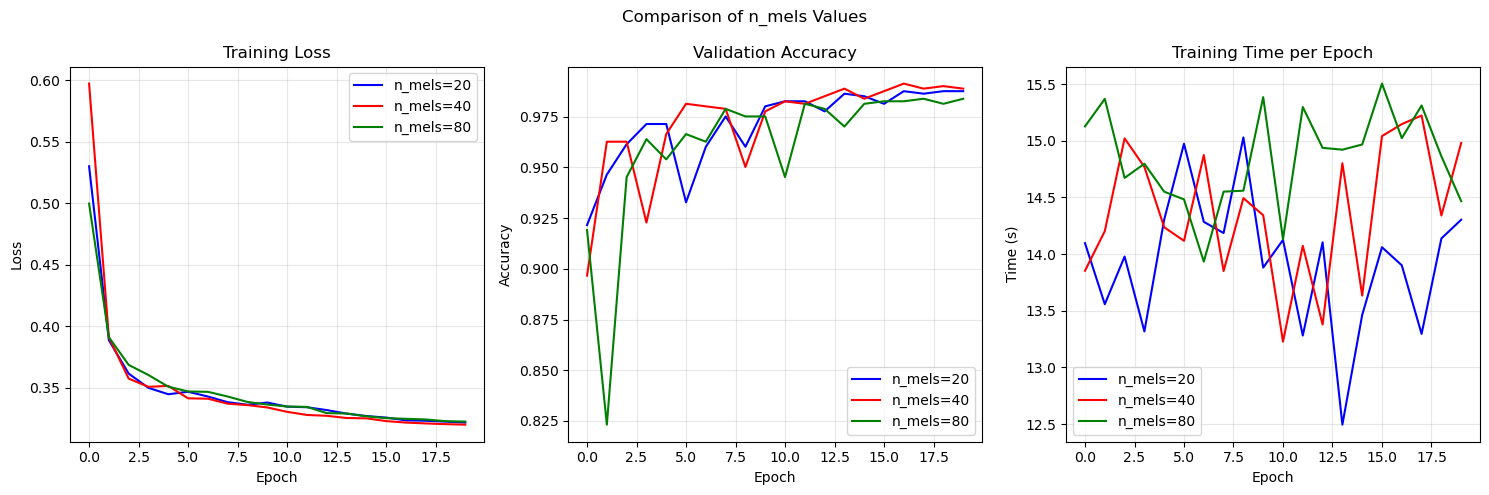


Final metrics comparison:
Experiment      Final Loss      Final Val Acc   Avg Epoch Time 
------------------------------------------------------------
n_mels=20       0.3215          0.9875          13.94          s
n_mels=40       0.3198          0.9888          14.38          s
n_mels=80       0.3223          0.9838          14.84          s


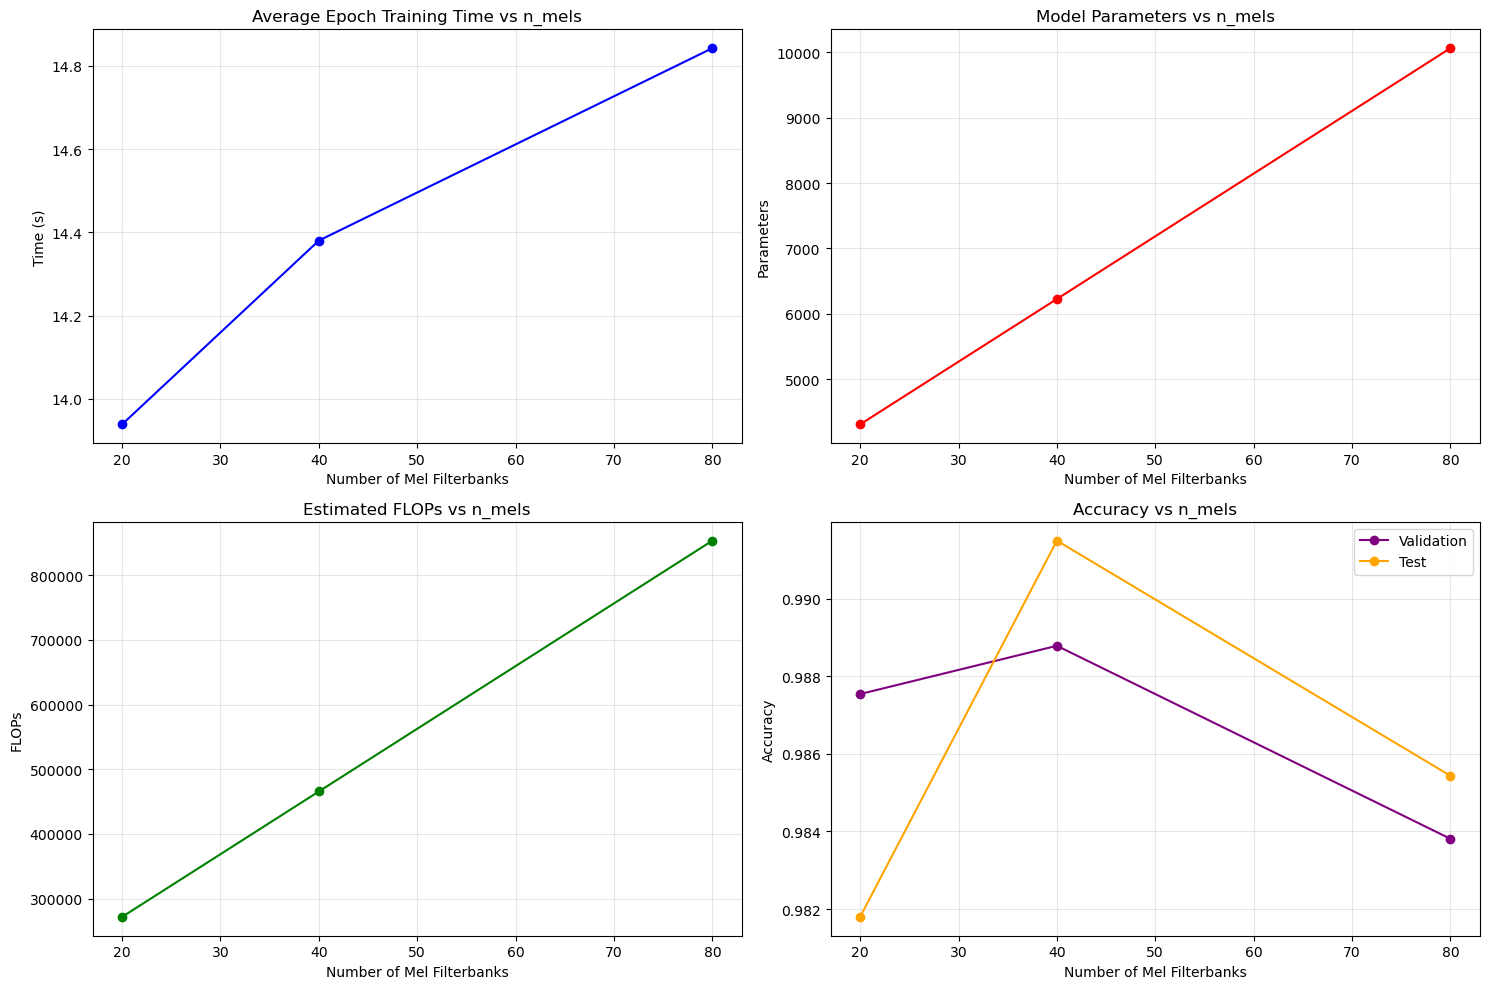


Summary of Results:
n_mels     Train Time      Val Acc         Test Acc        Params          FLOPs          
-------------------------------------------------------------------------------------
20         13.94           0.9875          0.9818          4,306           271,595        
40         14.38           0.9888          0.9915          6,226           465,515        
80         14.84           0.9838          0.9854          10,066          853,355        


In [40]:
# Run experiments with different n_mels values
n_mels_values = [20, 40, 80]
all_metrics, test_accuracies = run_n_mels_experiments(
    n_mels_values=n_mels_values,
    num_epochs=20,
    batch_size=32,
    lr=3e-3,
    device=device
)

### Experiment setup - groups (Conv1d) 

In [29]:
def plot_combined_groups_metrics(metrics_dict, title="Comparison of Groups Values"):
    """
    Plot training metrics from multiple groups experiments on the same graphs.
    """
    plt.figure(figsize=(15, 5))
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
    
    # Plot 1: Training Loss
    plt.subplot(1, 3, 1)
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        color = colors[i % len(colors)]
        plt.plot(metrics['train_loss'], color=color, label=name)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 2: Validation Accuracy
    plt.subplot(1, 3, 2)
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        color = colors[i % len(colors)]
        plt.plot(metrics['val_acc'], color=color, label=name)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 3: Training Time
    plt.subplot(1, 3, 3)
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        color = colors[i % len(colors)]
        plt.plot(metrics['train_time'], color=color, label=name)
    plt.title('Training Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    # Print final metrics for each experiment
    print("\nFinal metrics comparison:")
    print(f"{'Experiment':<15} {'Final Loss':<15} {'Final Val Acc':<15} {'Avg Epoch Time':<15}")
    print("-" * 60)
    
    for name, metrics in metrics_dict.items():
        final_loss = metrics['train_loss'][-1]
        final_acc = metrics['val_acc'][-1]
        avg_time = sum(metrics['train_time']) / len(metrics['train_time'])
        print(f"{name:<15} {final_loss:<15.4f} {final_acc:<15.4f} {avg_time:<15.2f}s")

In [ ]:
def plot_groups_summary(results):
    """
    Plot summary results from groups experiments.
    """
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Training Time vs Groups
    plt.subplot(2, 2, 1)
    plt.plot(results['groups'], results['train_time'], 'o-', color='blue')
    plt.title('Average Epoch Training Time vs Groups')
    plt.xlabel('Groups')
    plt.ylabel('Time (s)')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Parameters vs Groups
    plt.subplot(2, 2, 2)
    plt.plot(results['groups'], results['params'], 'o-', color='red')
    plt.title('Model Parameters vs Groups')
    plt.xlabel('Groups')
    plt.ylabel('Parameters')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: FLOPs vs Groups
    plt.subplot(2, 2, 3)
    plt.plot(results['groups'], results['flops'], 'o-', color='green')
    plt.title('Estimated FLOPs vs Groups')
    plt.xlabel('Groups')
    plt.ylabel('FLOPs')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Accuracy vs Groups
    plt.subplot(2, 2, 4)
    plt.plot(results['groups'], results['val_acc'], 'o-', color='purple', label='Validation')
    plt.plot(results['groups'], results['test_acc'], 'o-', color='orange', label='Test')
    plt.title('Accuracy vs Groups')
    plt.xlabel('Groups')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nSummary of Results:")
    print(f"{'Groups':<10} {'Train Time':<15} {'Val Acc':<15} {'Test Acc':<15} {'Params':<15} {'FLOPs':<15}")
    print("-" * 85)
    
    for i, g in enumerate(results['groups']):
        print(f"{g:<10} {results['train_time'][i]:<15.2f} {results['val_acc'][i]:<15.4f} "
              f"{results['test_acc'][i]:<15.4f} {results['params'][i]:<15,} {results['flops'][i]:<15,}")

In [31]:
def run_groups_experiments(n_mels=40, groups_values=[1, 2, 4, 8], num_epochs=10, batch_size=32, lr=3e-3, device='cuda'):
    """
    Run experiments with different groups values and collect the results.
    """
    from datetime import datetime
    import os
    
    # Create data loaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    test_loader = DataLoader(test_set, batch_size=batch_size)
    
    # Results storage
    all_metrics = {}
    results = {
        'groups': [],
        'train_time': [],
        'val_acc': [],
        'test_acc': [],
        'params': [],
        'flops': []
    }
    
    # Run experiments for each groups value
    for groups in groups_values:
        print(f"\n{'='*50}")
        print(f"Running experiment with groups={groups}")
        print(f"{'='*50}\n")
        
        # Skip if n_mels is not divisible by groups
        if n_mels % groups != 0:
            print(f"Skipping groups={groups} as {n_mels} is not divisible by {groups}")
            continue
        
        # Create model with the specified groups
        model = LogMelCNN(n_mels=n_mels, groups=groups)
        model = model.to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        # Create TensorBoard writer
        log_dir = os.path.join("runs", f"groups_{groups}_{datetime.now().strftime('%Y%m%d-%H%M%S')}")
        writer = SummaryWriter(log_dir=log_dir)
        
        # Train the model
        trained_model, metrics = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            num_epochs=num_epochs,
            writer=writer,
            device=device,
            n_mels=n_mels
        )
        
        # Evaluate the model
        test_acc = evaluate_model(trained_model, test_loader, device=device, n_mels=n_mels)
        
        # Count parameters
        param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        # Estimate FLOPs
        sample_features = LogMelFilterBanks(n_fft=400, hop_length=160, n_mels=n_mels)(next(iter(train_loader))[0][:1])
        time_dim = sample_features.shape[2]
        
        # Estimate FLOPs for each layer with groups
        conv1_flops = (32 * 3 * n_mels * time_dim) // groups  # Conv1d with groups
        pool1_flops = time_dim // 2  # MaxPool1d
        time_dim = time_dim // 2
        
        conv2_flops = (16 * 3 * 32 * time_dim) // groups  # Conv2d with groups
        pool2_flops = time_dim // 2  # MaxPool1d
        time_dim = time_dim // 2
        
        fc_in_features = 16 * time_dim
        fc_flops = 2 * fc_in_features  # Linear layer
        
        total_flops = conv1_flops + pool1_flops + conv2_flops + pool2_flops + fc_flops
        
        # Store results
        all_metrics[f"groups={groups}"] = metrics
        results['groups'].append(groups)
        results['train_time'].append(sum(metrics['train_time']) / len(metrics['train_time']))  
        results['val_acc'].append(metrics['val_acc'][-1])  
        results['test_acc'].append(test_acc)
        results['params'].append(param_count)
        results['flops'].append(total_flops)
    
  
    plot_combined_groups_metrics(all_metrics, title="Comparison of Groups Values")
    plot_groups_summary(results)
    
    return all_metrics, results


Running experiment with groups=1

Trainable Parameters: 6,226
Sample features shape: torch.Size([32, 40, 101])


C:\Users\NUC\AppData\Local\Temp\ipykernel_8268\896459238.py:24: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape[1] != self.n_mels:
C:\Users\NUC\AppData\Local\Temp\ipykernel_8268\896459238.py:37: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.size(1) != self.fc1.in_features:


Epoch 1/20 | Loss: 0.5550 | Val Acc: 0.9166 | Time: 12.5s | LR: 3.13e-04
Epoch 2/20 | Loss: 0.3942 | Val Acc: 0.9228 | Time: 12.1s | LR: 8.41e-04
Epoch 3/20 | Loss: 0.3658 | Val Acc: 0.9465 | Time: 12.5s | LR: 1.56e-03
Epoch 4/20 | Loss: 0.3563 | Val Acc: 0.9514 | Time: 11.4s | LR: 2.28e-03
Epoch 5/20 | Loss: 0.3519 | Val Acc: 0.9440 | Time: 12.6s | LR: 2.81e-03
Epoch 6/20 | Loss: 0.3471 | Val Acc: 0.9664 | Time: 12.9s | LR: 3.00e-03
Epoch 7/20 | Loss: 0.3452 | Val Acc: 0.9726 | Time: 12.8s | LR: 2.96e-03
Epoch 8/20 | Loss: 0.3418 | Val Acc: 0.9365 | Time: 15.0s | LR: 2.85e-03
Epoch 9/20 | Loss: 0.3421 | Val Acc: 0.9701 | Time: 14.8s | LR: 2.67e-03
Epoch 10/20 | Loss: 0.3386 | Val Acc: 0.9589 | Time: 15.5s | LR: 2.43e-03
Epoch 11/20 | Loss: 0.3366 | Val Acc: 0.9577 | Time: 15.9s | LR: 2.15e-03
Epoch 12/20 | Loss: 0.3348 | Val Acc: 0.9813 | Time: 15.9s | LR: 1.83e-03
Epoch 13/20 | Loss: 0.3347 | Val Acc: 0.9801 | Time: 15.3s | LR: 1.50e-03
Epoch 14/20 | Loss: 0.3325 | Val Acc: 0.9838 | 

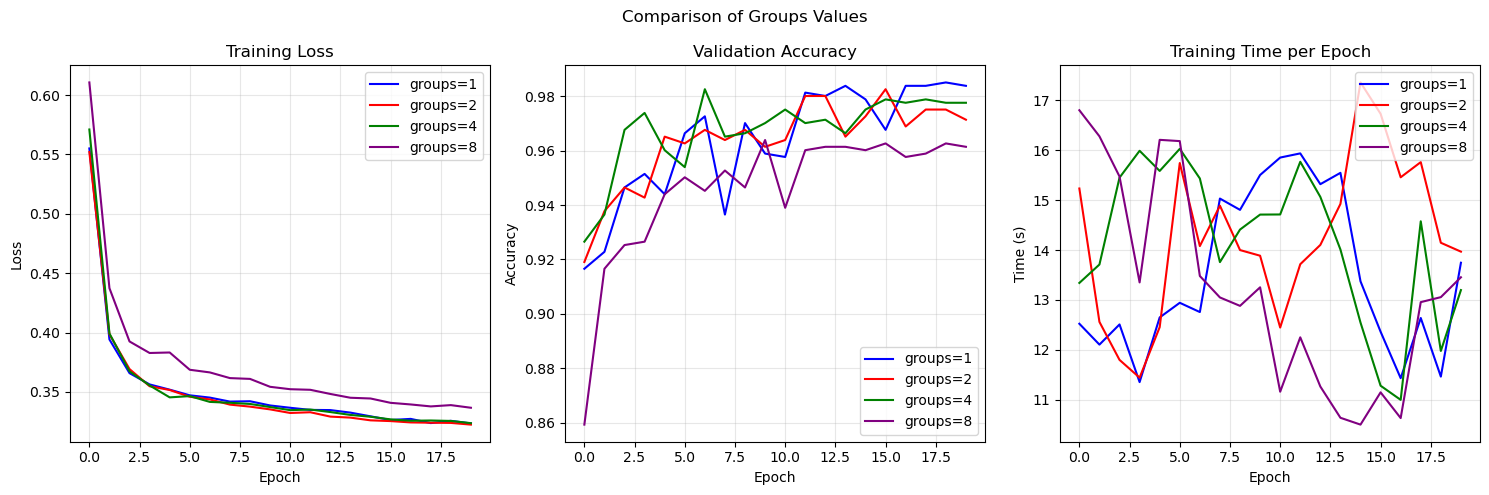


Final metrics comparison:
Experiment      Final Loss      Final Val Acc   Avg Epoch Time 
------------------------------------------------------------
groups=1        0.3234          0.9838          13.49          s
groups=2        0.3224          0.9714          14.24          s
groups=4        0.3237          0.9776          14.13          s
groups=8        0.3366          0.9614          13.20          s


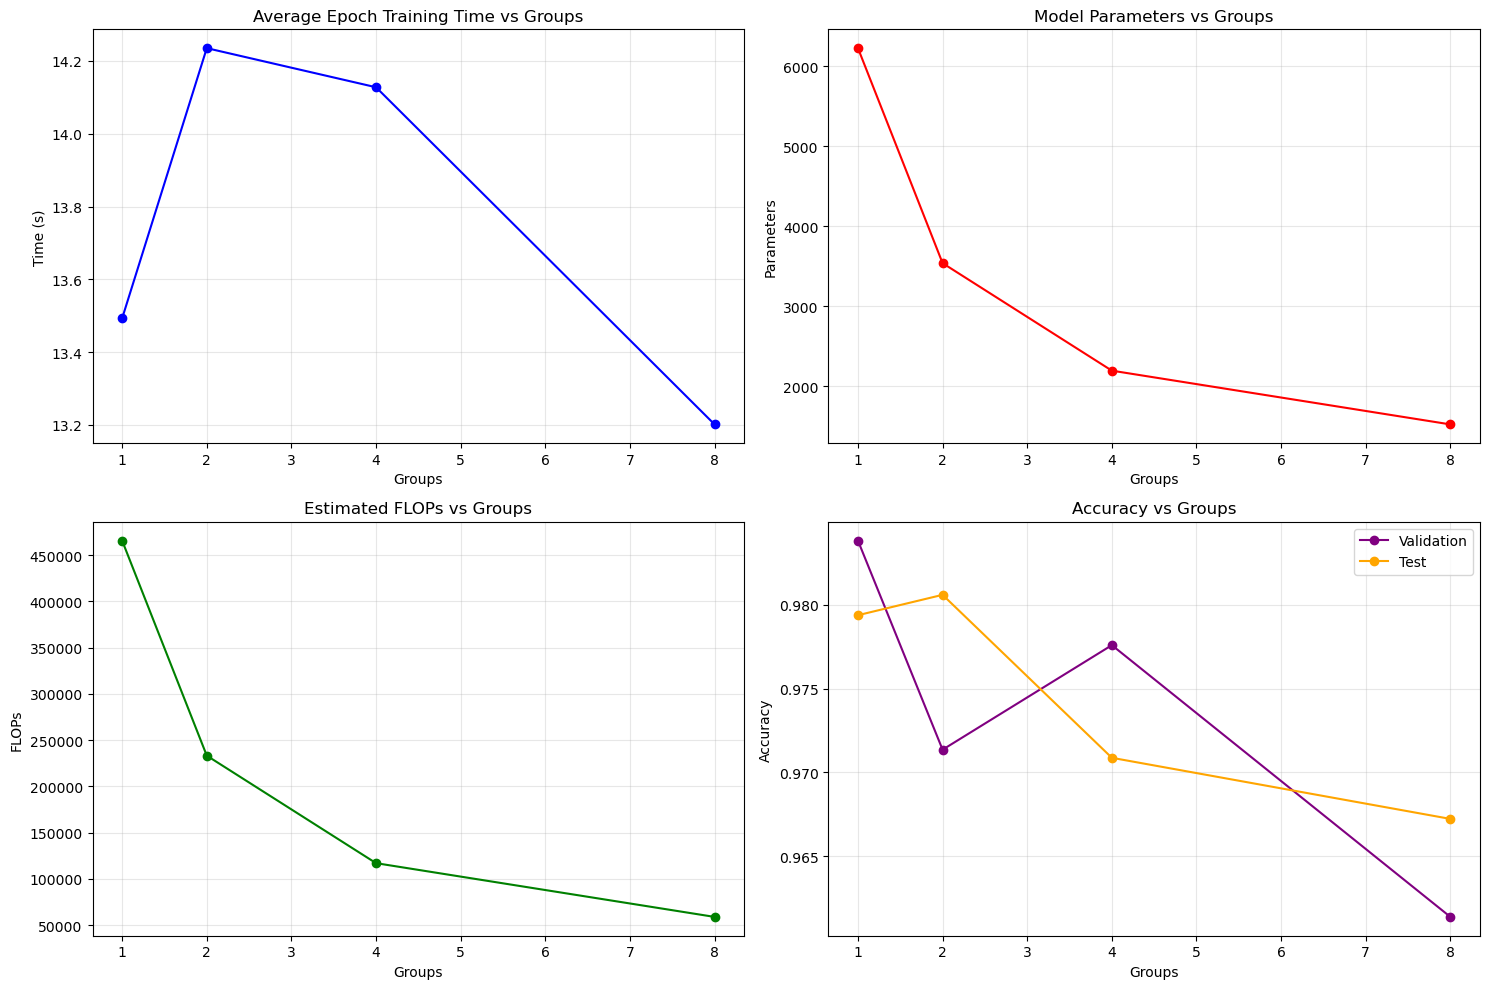


Summary of Results:
Groups     Train Time      Val Acc         Test Acc        Params          FLOPs          
-------------------------------------------------------------------------------------
1          13.49           0.9838          0.9794          6,226           465,515        
2          14.24           0.9714          0.9806          3,538           233,195        
4          14.13           0.9776          0.9709          2,194           117,035        
8          13.20           0.9614          0.9672          1,522           58,955         


In [33]:
# Run experiments with different groups values
n_mels = 40  
groups_values = [1, 2, 4, 8] 

# Run the experiments
groups_results = run_groups_experiments(
    n_mels=n_mels,
    groups_values=groups_values,
    num_epochs=20,  
    batch_size=32,
    lr=3e-3,
    device=device
)